In [3]:
from numpy import log, exp, sqrt
from scipy import linalg
from scipy.optimize import check_grad
import numpy as np
import matplotlib.pyplot as plt
import time

In [11]:
# Prepare Data
from diabeticRetinopathyUtils import load_diabetic_retinopathy

X, y = load_diabetic_retinopathy(filename="diabeticRetinopathy.csv")
n,p = X.shape
X_ = np.column_stack((np.ones(n), X))

## Question 1.1

### Computing the value, gradient and hessian of the objective function $f$

The goal is to find $ (w_0^*, w^*) = \underset{w_0 \in \mathbb{R}, w \in \mathbb{R}^n}{arg min} f(w_0, w)$ where $$f(w_0, w) = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-y_i\left(X_i^Tw+w_0\right)}\right)} + \frac{\rho}{2}{\|w\|}^2_2$$


The gradient will be :

$$ \nabla f(w_{0},w ) =\big ( \frac {\partial f}{\partial w_0} ,  \frac {\partial f}{\partial w} \big) = \big( \frac{1}{n}\sum_{i=1}^{n}\frac{-y_{i}}{1 + exp(y_{i}(X_{i}^T w + w_{0}))} , \frac{1}{n}\sum_{i=1}^{n}\frac{-X_{i} y_{i}}{1 + exp(y_{i}(X_{i}^T w + w_{0}))} + \rho w  \big)   $$


The Hessian matrix will be : 


Let $ z_{i} = X_{i}^T w +w_{0} $

$$ \frac {\partial^2 f}{\partial w_0 ^2} =  \frac {1}{n} \sum_{i=1}^{n} \frac {exp(y_{i}z_{i})y_{i}^2}{( 1 + exp(y_{i}z_{i}))^2}  $$

$$ \frac {\partial^2 f}{\partial w_0 \partial w} =  \frac {1}{n} \sum_{i=1}^{n} \frac {X_{i}^{T} y_{i}^2 exp(y_{i}z_{i})}{( 1 + exp(y_{i}z_{i}))^2} $$

$$ \frac {\partial^2 f}{\partial w \partial w_0} =  \frac {1}{n} \sum_{i=1}^{n} \frac {X_{i} y_{i}^2 exp(y_{i}z_{i})}{( 1 + exp(y_{i}z_{i}))^2} $$

$$ \frac {\partial^2 f}{\partial w ^2} =  \frac {1}{n} \sum_{i=1}^{n} \frac {X_{i}X_{i}^{T} y_{i}^2  exp(y_{i}z_{i})}{( 1 + exp(y_{i}z_{i}))^2}  + \rho I$$

$$
Hessian(f) = 
    \begin{pmatrix} 
    \frac {\partial^2 f}{\partial w_0 ^2} &  \frac {\partial^2 f}{\partial w_0 \partial w}\\
    \frac {\partial^2 f}{\partial w \partial w_0} & \frac {\partial^2 f}{\partial w ^2} 
    \end{pmatrix}
$$

$$
Hessian(f) = \frac {1}{n} \sum_{i=1}^{n} \frac {exp(y_{i}z_{i})y_{i}^2}{( 1 + exp(y_{i}z_{i}))^2}
    \begin{pmatrix} 
    1 &  X_{i}^{T}\\
    X_{i} &  X_{i}X_{i}^{T}
    \end{pmatrix}
    +
    \begin{pmatrix} 
    0 &  \bold 0\\
    \bold 0 &  \rho I
    \end{pmatrix}
$$
#### We can see that every element of the hessian matrix is positive, so we can say that the hessian matrix is positive and the objetive funtion is convex.

## Question 1.2

In [4]:
rho = 1.0 / X.shape[0]
w=np.ones(X.shape[1])

In [80]:
def objective_function(w0, w, X, y, rho):
    
    n, m = X.shape
    z = [np.dot(X[i], w) + w0 for i in range(n)]

    # VALUE
    summands = [log(1 + exp(-y[i] * z[i])) for i in range(n)]
    func = (1 / n) * sum(summands) + (rho / 2) * np.linalg.norm(w)**2

    # GRADIENT
    summands = [-y[i] / (1 + exp(y[i] * z[i])) for i in range(n)]
    grad_w0 = (1 / n) * sum(summands)

    summands = [-X[i] * y[i] / (1 + exp(y[i] * z[i])) for i in range(n)]
    grad_w = (1 / n) * sum(summands) + rho * w

    # HESSIAN
    ex = [exp(y[i] * z[i]) for i in range(n)]

    block0 = [ex[i] * y[i]**2 / (1 + ex[i])**2 for i in range(n)]

    block1 = [X[i] * (ex[i] * y[i]**2 / (1 + ex[i])**2) for i in range(n)]

    block2 = [np.outer(X[i], X[i]) * ex[i] * y[i]**2 /
              (1 + ex[i])**2 for i in range(n)]

    block0 = (1 / n) * sum(block0)

    block1 = (1 / n) * sum(block1)

    block2 = (1 / n) * sum(block2) + rho * np.eye(m)

    hessian = np.block([
        [block0,      block1.reshape(1, m)],
        [block1.reshape(m, 1),  block2]
    ])

    return func, np.append(grad_w0, grad_w), hessian

In [81]:
def func(w_):
    w0 = w_[0]
    w = w_[1:]
    val, grad, hessian = objective_function(w0, w, X, y, rho)
    return val

def grad(w_):
    w0 = w_[0]
    w = w_[1:]
    val, grad, hessian = objective_function(w0, w, X, y, rho)
    return grad

In [82]:
rho = 1.0 / X.shape[0]
epsilon = 1e-10
w0 = 0.0
w = np.zeros(X.shape[1])

print(check_grad(func, grad, np.append(w0, w)))

5.56968199646e-06


## Question 1.3

In [83]:
def newton(f, w0, w, X, y, rho, epsilon):

    val, grad, hessian = objective_function(w0, w, X, y, rho)

    norm = np.linalg.norm(grad[1:])
    k = 0

    while(norm > epsilon):
        l = np.append(w0, w) - np.linalg.solve(hessian, grad)
        w0 = l[0]
        w = l[1:]

        val, grad, hessian = objective_function(w0, w, X, y, rho)

        norm = np.linalg.norm(grad[1:])

        k = k + 1

    return val, np.append(w0,w), k

In [84]:
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 0.0
w = np.zeros(X.shape[1])

val, w_, k = newton(objective_function, w0, w, X, y, rho, epsilon)

w_

array([ 0.67731198,  0.28526576, -0.24554742,  5.61365006,  0.9888679 ,
       -1.82791918, -2.55695256, -1.58747255,  0.43396361,  0.48515529,
       -0.40441764,  0.17280405, -0.57564945,  0.43832626, -0.62435831,
        1.25356177,  0.72621094, -0.00607139, -0.1490878 , -0.09505212])

## Question 1.4

####  Answer : we find the problem of overflow !!

In [85]:
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 0.3
w = 0.3 * np.ones(X.shape[1])

val, w_, k = newton(objective_function, w0, w, X, y, rho, epsilon)

/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/alexandrema/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/User

## Question 1.5

In [86]:
def func(w_):
    w0 = w_[0]
    w = w_[1:]
    val, grad, hessian = objective_function(w0, w, X, y, rho)
    return val


def armijo(w_, func, grad, hessi_grad, a, b):
    k = 1.0
    beta = 0.5
    gamma = b * (a**k)

    while (func(w_ - gamma * hessi_grad) > func(w_) - beta * gamma * np.sum(grad * hessi_grad)):
        k = k + 1.0
        gamma = b * (a**k)

    return gamma

#### The parameters of Armijo function are $a = 0.9, b = 2\gamma_{k-1}, \beta = 0.5$</p>

In [87]:
def newton_linear_search(objective_function, w0, w, X, y, rho, epsilon, numMax):

    val, grad, hessian = objective_function(w0, w, X, y, rho)
    norm = np.linalg.norm(grad[1:])
    k = 0.0
    a = 0.9
    gamma = 1.0
    array_norm = [norm]  # array of norm
    hessi_grad = np.linalg.solve(hessian, grad)

    while(norm > epsilon and k < numMax):

        gamma = armijo(np.append(w0, w), func, grad, hessi_grad, a, 2 * gamma)
        l = np.append(w0, w) - gamma * hessi_grad
        w0 = l[0]
        w = l[1:]

        val, grad, hessian = objective_function(w0, w, X, y, rho)
        hessi_grad = np.linalg.solve(hessian, grad)

        norm = np.linalg.norm(grad[1:])
        array_norm.append(norm)
        k = k + 1

    return val, np.append(w0, w), array_norm, k

In [94]:
#Inicialization of the parameters
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 0.3
w = 0.3 * np.ones(X.shape[1])


# Using the Newton's method with linear search
time1 = time.time()
val, w_, array_norm, k = newton_linear_search(objective_function, w0, w, X, y, rho, epsilon, 30)
time2 = time.time()

print("The value minimal of the objective function :",val)
print("The variable minimal of the objective function : \n",w_)
print("Times of iterations: ", k)
print("Time used : ", (time2 - time1))

The value minimal of the objective function : 0.53001887163
The variable minimal of the objective function : 
 [ 0.67731198  0.28526576 -0.24554742  5.61365006  0.98886789 -1.82791918
 -2.55695256 -1.58747255  0.43396361  0.48515529 -0.40441764  0.17280405
 -0.57564945  0.43832626 -0.62435827  1.25356179  0.72621093 -0.00607139
 -0.1490878  -0.09505212]
Times of iterations:  9.0
Time used :  4.929593801498413


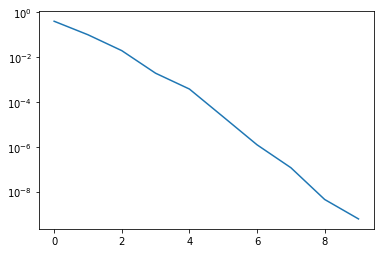

In [89]:
fig = plt.figure(2)
plt.semilogy(array_norm)
plt.show()

## Question 2.1

#### We can't use the Newton Method, because the objective function is not differentiable.

## Question 2.2

## Question 2.3

In [38]:
def f2(w,X,y):
    z = [np.dot(X[i], w) for i in range(n)]
    summand = [log(1+exp(-y[i]*z[i])) for i in range(n)]
    return 1.0/n*sum(summand)

def grad2(w,X,y):
    z = [np.dot(X[i], w) for i in range(n)]
    summand = [-y[i]/(1+exp(y[i]*z[i]))*X[i].T for i in range(n)]
    return np.ravel(1.0/n * sum(summand))

def g2(w,rho):
    return rho * np.linalg.norm(w,ord=1)

def F2(w,X,y,rho):
    return f2(w,X,y) + g2(w,rho)

def objective_total2(w, X, y, rho):
    return f2(w,X,y), grad2(w,X,y),F2(w,X,y,rho)

In [42]:
def softThred(w,rho):
    sw = np.zeros_like(w)
    sw[w > rho] = w[w > rho] - rho
    sw[w < -rho] = w[w < -rho] + rho
    sw[0] = w[0]
    return sw

def proximal(g, w0, X, y, rho, tolerance = 1e-10, max_iter = 1e2):
    a,b = 0.5,1
    1
    val, grad, valF= g(w0, X, y, rho)
    diff = tolerance + 1
    k = 0
    while((diff > tolerance) and (k <= max_iter)):
        gamma = b
        wk = softThred(w0 - gamma*grad, gamma*rho)
        valk, gradk, valFk = g(wk, X, y, rho)
        while(valk > val+np.sum(grad*(wk - w0)) + np.sum((w0 - wk)**2)/(2*gamma)):
            gamma = gamma * a
            wk = softThred(w0 - gamma*grad, gamma*rho)
            valk, gradk, valFk = g(wk, X, y, rho)
        diff = valF - valFk
        w0 = wk
        val, grad, valF = g(w0, X, y, rho)
        b = 2 * gamma
        k = k + 1    
    return valF, w0, k


In [41]:
rho = 0.1
time1 = time.time()
w = 0.5*np.ones_like(X_[0])
val, sol_l1, k = proximal(objective_total2, w, X_, y, rho, 1e-10)
time2 = time.time()

print("{} Iterations done in {} seconds.".format(k,time2-time1))
print("Results: ")
print(val)
print(sol_l1)

8 Iterations done in 0.3078184127807617 seconds.
Results: 
0.699475942399
[ 0.12517042  0.          0.          0.18774642  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


## Question 3.1

#### Properties of the two problems:

While both objective functions are convex, it is also differentiable in the first problem, while this isn't the case in the second problem.

Newton's method converges fast if the initial values are in the convergence zone. Generally, the L2 Norm is 



## Question 3.2

#### Ridge vs. Lasso:

Lasso regularizaton favors a sparse representation, i.e. tends to set predictors to zero.
Ridge regression does not show this behavior.